#1. Setup & Data import 

In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'add project name' # Project ID inserted based on the query results selected to explore
location = 'add location' # Location inserted based on the query results selected to explore

client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [ ]:
####test data import 

In [ ]:
%load_ext google.colab.data_table

In [ ]:
%%bigquery df --project  add project name 

SELECT  user_nickname ,distinct_id,chat_room_id, chat_room_name, user_type, time, product_price, message_length, chat_celeb_nickname

FROM `add project name.project_name`

WHERE (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')

Query is running:   0%|          |

Downloading: |          |

In [ ]:
df

#2. EDA 

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df_celeb = df[df['user_type']=='CELEB']
df_celeb = df_celeb.groupby(['user_nickname','chat_room_id','chat_room_name']).sum()
df_celeb

In [ ]:
df_fan = df[df['user_type']=='FAN']
df_fan = df_fan.groupby(['user_nickname','chat_room_id','chat_room_name']).sum()
df_fan

In [ ]:
df_fan.isnull().sum()

#3. Preprocessing


## 3.1.How to deal Nan values! 


**if identification column appears as NaN **-> delete (the target of this project refers to activated users) 

if other columns appear as NaN **굵은 텍스트**
- product_price : NaN refers to unpurchasement -> fill NaN values with 0 
- message length : NaN refers to no message (just looking) -> fill NaN values with 0 




---


신원확인 컬럼이 nan 인 경우 → 고유 id 만 살리고 모델링 → 추후에 병합 

그 외 컬럼들이 nan 인 경우 → 

1. product_price 는 “보낸 샷” → 0은 보내지 않았다는 뜻
2.  message_length 가 0이라는 것은? → 채팅을 보내지 않고 접속만 했다

따라서 product_price, message_length 모두 nan 인 경우는 0으로 처리 

In [ ]:
def fillna(df):
  df['product_price'] = df['product_price'].fillna(0)
  df['product_price_string'] = df['product_price_string'].fillna(0)
  #df['message_length'] = df['message_length'].fillna(0)
  return df

## 3.2. Change Type 

product_price & product_price_string should be int

In [ ]:
def type_change(df):
  df['product_price_string'] = df['product_price_string'].astype('string')
  df['product_price_string'] = df['product_price_string'].astype('int')
  df['product_price'] = df['product_price'].astype('int')
  return df

## 3.3. Make Chat room host column 


using chat_celeb_nickname column 

if celeb has ever used the message function once, chat_celeb_nickname column appears to be the host 

if celeb hasn't ever used the message function, thus chat_celeb_nickname column shows Null, there's no other way to create the host name, Plus, the amount of Null celebs is small -> drop column



---



1. chat_celeb_nickname 컬럼을 이용해서 만듬 

- 채팅을 친 경우 chat_celeb_nickname = 채팅방 주인 컬럼에 해당 내용 추가,이후 채팅방 주소와 1:1 매칭되는 dict 생성해서 붙여넣기 처리 

- 채팅을 한번도 치지 않아 chat_celeb_nickname 이 null 인 경우 -> 약 1만개 데이터가 이 경우에 해당함, 낮은 값이기 때문에 현재로서 drop 처리 

In [ ]:
%%bigquery chat_host --project  add project name 

SELECT chat_room_id, chat_celeb_nickname

FROM add project_name

WHERE (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (message_length > 0)
AND (chat_celeb_nickname !='')
AND (chat_room_id !='')

GROUP BY chat_room_id, chat_celeb_nickname

In [ ]:
chat_host

In [ ]:
dict_host ={}

for row, val in df['chat_celeb_nickname'].items():
    if val: #if celeb has ever used the message function once
        name = str(val)
        dict_host[name] = df['chat_room_id'][row]

In [ ]:
def chat_room_host(df):
  for key,val in dict_host.items():
    if val == df['chat_room_id'].values:
      print(val)

In [ ]:
def find_chat_room_host(id) :
  for p,q in dict_host.items():
      if q == id:
        return p

In [ ]:
df['chat_room_host'] = df['chat_room_id'].apply(find_chat_room_host)

In [ ]:
df.isnull().sum()

## 3.4 Find which room the fans are using (which celeb they are following)


- Find every fan who has ever done something in the app for three months
- Using this data, exclude users who hasn't ever used the app for a month, and name them after "churned fan" 



---



- 3개월동안 특정 셀럽의 방에서 어떤 행동을 한 팬은 전부 추출 
- 차후 해당 리스트에서 당월 집계에 포함되지 않은 모든 팬은 이탈팬으로 간주 

In [ ]:
%%bigquery host_user --project  add project name 

SELECT chat_room_id, user_nickname, chat_celeb_nickname

FROM add project_name

WHERE (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (chat_room_id !='')
AND (user_nickname != "")


GROUP BY chat_room_id,chat_celeb_nickname, user_nickname

ORDER BY chat_celeb_nickname

In [ ]:
host_user

### 3. 5. Find how many room does the user are joining (number of following celebs for fans)

In [ ]:
%%bigquery user_room_count  --project  add project name

SELECT user_nickname, count(DISTINCT chat_room_id) AS room_num

FROM add project_name

WHERE (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (chat_room_id !='')
AND (user_nickname != "")

GROUP BY user_nickname

ORDER BY user_nickname

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
user_room_count

#4. Make Score column

#### 4.1. Total amount of purchasement (ThankUSticker)


***made_sticker_total***

- is sum of product_price and prodct_price_string 
- add host's filtering condition 
- add log data's tag condition (send_thankU_sticker in mp_event_name) 
- add log data's tag condition (Purchase in ecommerce_step)
- only activated user



---




- product_price + product_price_string 합계 
- 채팅방 주인(닉네임 말고 아이디) 필터 조건 
- 그 중에 mp_event_name 이 send_thankU_sticker 인 것 
- 중에 ecommerce_step 이이'Purchase' 인 것 
- 탈퇴한 회원은 X, 팬 이름 없으면 제외시킴

In [ ]:
%%bigquery made_sticker_total --project  add project name 


SELECT  chat_room_id, user_nickname, product_price_string, product_price

FROM add project_name

WHERE ((product_price_string IS NOT NULL) OR (product_price>0)) 
AND (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND ((ecommerce_step = 'Purchase'))
AND (mp_event_name ='send_thankU_sticker')
AND (user_nickname !='')
AND (chat_room_id !='')


ORDER BY chat_room_id;

In [ ]:
made_sticker_total

In [ ]:
#change data type
made_sticker_total['product_price_string'] = made_sticker_total['product_price_string'].astype('int')

#fill nan values
made_sticker_total = fillna(made_sticker_total)

In [ ]:
# turn into score values
def made_sticker_total_func(df):
  df = df.groupby(['chat_room_id','user_nickname']).sum()
  df = df.reset_index()
  df['made_sticker_total'] = df['product_price_string'] + df['product_price']
  return df

In [ ]:
made_sticker_total = made_sticker_total_func(made_sticker_total)
made_sticker_total

###4.2. Frequency of purchasement ***made_sticker_freq***


- divide the sum of product_price + product_price_string as 4 weeks
- add host's filtering condition 
- add log data's tag condition (send_thankU_sticker in mp_event_name) 
- add log data's tag condition (Purchase in ecommerce_step)
- only activated user



---





- product_price + product_price_string 의 count 합계를 4주로 나눈 것
- 채팅방 주인(닉네임 말고 아이디) 필터 조건 
- 그 중에 mp_event_name 이 send_thankU_sticker 인 것 
- 중에 ecommerce_step 이이'Purchase' 인 것 
- 탈퇴한 회원은 X, 팬 이름 없으면 제외시킴



In [ ]:
%%bigquery made_sticker_freq --project  add project name 


SELECT chat_room_id, user_nickname, COUNT(product_price_string) AS product_price_string , COUNT(product_price) AS product_price

FROM add project_name

WHERE ((product_price_string IS NOT NULL) OR (product_price>0)) 
AND (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND ((ecommerce_step = 'Purchase'))
AND (mp_event_name ='send_thankU_sticker')
AND (user_nickname !='')
AND (chat_room_id !='')


GROUP BY chat_room_id, user_nickname

ORDER BY chat_room_id;

In [ ]:
made_sticker_freq

In [ ]:
#change data type
made_sticker_freq['product_price_string'] = made_sticker_freq['product_price_string'].astype('int')

#fill nan values
made_sticker_freq = fillna(made_sticker_freq)

In [ ]:
# turn into score values
def made_sticker_freq_func(df):
  df['made_sticker_freq'] = (df['product_price_string'] + df['product_price']) / 4
  return df

In [ ]:
made_sticker_freq = made_sticker_freq_func(made_sticker_freq)
made_sticker_freq

### 4.3. Total amount of message sent

 ***made_text_total***

- total Counts of message length by chat room by individual fan 
- exclude if user_nickname and chat_celeb_nickname is same (refers to celeb replying on their own room)
- only activated users 



---



- message_length 의 채팅방별 팬별 count 의 합계
- user_nickname 과 chat_celeb_nickname 이 같으면 제외 (셀럽이 답장한거임)
- 탈퇴한 회원은 X, 팬 이름 없으면 제외시킴

In [ ]:
%%bigquery  made_text_total --project  add project name 

SELECT chat_room_id, user_nickname, COUNT(message_length) AS message_count

FROM add project_name

WHERE (message_length IS NOT NULL) 
AND (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (user_nickname !='')
AND (chat_room_id !='')
AND (user_nickname != chat_celeb_nickname)

GROUP BY chat_room_id, user_nickname


In [ ]:
made_text_total

In [ ]:
made_text_total = made_text_total.rename(columns = {'message_count':'made_text_total'})

In [ ]:
made_text_total.info()

###4.4. Total amount of Likes


  ***made_like_total***

- Like from chat_room_btn_icon_name
- only activated users 



---




- chat_room_btn_icon_name 이 Like 로 찍히는 것 중
- user_nickname 이 null 이 아닌 것 

In [ ]:
%%bigquery  made_like_total --project  add project name 

SELECT  chat_room_id, user_nickname, COUNT(chat_room_btn_icon_name) AS Liked

FROM add project_name

WHERE (chat_room_btn_icon_name = 'Like') 
AND (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (user_nickname IS NOT NULL)

GROUP BY chat_room_id, user_nickname

In [ ]:
made_like_total

#### 4.5. Total counts of joining room 


***made_room_count***

- there's a problem in data tracking (excluded this column finally)



---



- 현재 트래킹이 이상하게 되는 중임..
- screen name 이 'Chat Room Page' 로 찍히는 것 중
- 채팅방이나 닉네임이 null 이면 제외

In [ ]:
%%bigquery   made_room_count --project  add project name 

SELECT DISTINCT(chat_room_id), user_nickname, COUNT(screen_name) AS made_room_count

FROM add project_name

WHERE (screen_name = 'Chat Room Page') 
AND (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (user_nickname !='')
AND (chat_room_id !='')

GROUP BY chat_room_id, user_nickname

In [ ]:
made_room_count
made_room_count.info()

#### 4.6 Length of the sent message 

  ***made_message_length***

- average values of message_length column 
- and the user_type should be Fan 
- only activated users 



---






- message_length 의 평균
- 중에 유저 타입이 팬인 것 
- 채팅방이나 닉네임이 없다면 제외

In [ ]:
%%bigquery made_message_length --project  add project name 

SELECT  chat_room_id, user_nickname, ROUND(AVG(message_length),0) AS made_message_length

FROM add project_name

WHERE (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (user_nickname !='')
AND (chat_room_id !='')
AND (user_nickname != chat_celeb_nickname)

GROUP BY chat_room_id, user_nickname

In [ ]:
made_message_length

#### 4.8. Access time  ***made_access_time***


- exclude if celeb has spent time in their own room 




---





- 셀럽이 자기 채팅방에서 보낸 경우는 제외






In [ ]:
%%bigquery made_access_time --project  add project name 

select chat_room_id, user_nickname,time, chat_celeb_nickname

FROM add project_name

WHERE (time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59')
AND (user_nickname != chat_celeb_nickname)
AND (user_nickname!= '') 

ORDER BY chat_room_id, user_nickname, time, chat_celeb_nickname

In [ ]:
from datetime import timedelta

made_access_time['remain_test'] = timedelta(days=0,hours=0,minutes=0,seconds=0)
made_access_time

In [ ]:
# if there's no other sign in 2 min, think of it as they aren't using the app
# add every 2 minuite as using the app once

for row, val in made_access_time['user_nickname'].items():

  try:
    if made_access_time['user_nickname'][row] == made_access_time['user_nickname'][row+1]:
      timediff = made_access_time['time'][row+1]- made_access_time['time'][row] 

      if timediff < timedelta(days=0,hours=0,minutes=2,seconds=0):
         made_access_time['remain_test'][row] = timediff

      else:
        made_access_time['remain_test'][row] = timedelta(days=0,hours=0,minutes=2,seconds=0)

    else:
      made_access_time['remain_test'][row] = timedelta(days=0,hours=0,minutes=2,seconds=0)

  except:
     pass

In [ ]:
made_access_time

In [ ]:
import numpy as np

made_access_time = made_access_time.groupby('user_nickname').agg({'remain_test': np.sum})

In [ ]:
made_access_time = made_access_time.reset_index()
made_access_time

### Final merge

- The most important dataframe is chat_host here.-> if null, no reason to analyze -> drop 

- left join in order



---



* 여기서 가장 중요한 데이터프레임은 채팅방 주인을 나타내는 chat_host -> 없다면 분석 불가능
* chat_host 부터 순서대로 left join 시켜나감
*  made_room_count, made_text_total, made_like_total, made_message_length , made_sticker_total,made_sticker_freq,

In [ ]:
import pandas as pd

merge1 = pd.merge(chat_host, made_message_length , how='outer', on='chat_room_id')
merge1

In [ ]:
merge1.shape

In [ ]:
print(chat_host.shape)
print(made_message_length.shape)
print(merge1.shape)
print(merge1.info())

In [ ]:
merge2 = pd.merge(merge1, made_text_total, how='outer', on=['chat_room_id','user_nickname'])
merge2

In [ ]:
print(merge2.shape)
print(merge2.info())

In [ ]:
merge3 = pd.merge(merge2, made_like_total, how='outer', on = ['chat_room_id','user_nickname'])
merge3

In [ ]:
print(merge3.shape)
print(merge3.info())

In [ ]:
merge4 = pd.merge(merge3, made_message_length, how='outer', on = ['chat_room_id','user_nickname'] )
merge4

In [ ]:
print(merge4.shape)
print(merge4.info())

In [ ]:
merge5 = pd.merge(merge4, made_sticker_total, how='outer', on = ['chat_room_id','user_nickname'] )
merge5

In [ ]:
print(merge5.shape)
print(merge5.info())

In [ ]:
merge6 = pd.merge(merge5, made_sticker_freq, how='outer', on = ['chat_room_id','user_nickname'] )
merge6

In [ ]:
print(merge6.shape)
print(merge6.info())

In [ ]:
del merge6['product_price_string_x']
del merge6['product_price_x']
del merge6['product_price_y']
del merge6['product_price_string_y']

In [ ]:
merge7 = pd.merge(merge6, made_room_count, how='outer', on = ['chat_room_id','user_nickname'] )
merge7

In [ ]:
merge8 = pd.merge(merge7, made_access_time, how='outer', on = ['user_nickname'] )

merge8

In [ ]:
print(merge8.shape)
print(merge8.info())

In [ ]:
#Fillna

merge8['made_message_length_x'] = merge8['made_message_length_x'].fillna(0)
merge8['made_text_total'] = merge8['made_text_total'].fillna(0)
merge8['Liked'] = merge8['Liked'].fillna(0)
merge8['made_sticker_total'] = merge8['made_sticker_total'].fillna(0)
merge8['made_sticker_freq'] = merge8['made_sticker_freq'].fillna(0)
merge8['made_room_count'] = merge8['made_room_count'].fillna(0)

In [ ]:
merge8.head()

In [ ]:
merge8.columns

In [ ]:
del merge8['made_message_length_y']

In [ ]:
merge8['remain_test'] = merge8['remain_test'].dt.seconds
merge8['remain_test'] = merge8['remain_test'].fillna(0)

In [ ]:
merge8.head()

In [ ]:
merge8.info()

#5. Preprocessing

In [ ]:
# find duplicated data

dup = merge8.duplicated(['chat_room_id','user_nickname'])
print(dup.value_counts())

#remove
merge8.drop_duplicates(subset=['chat_room_id','user_nickname','remain_test'],ignore_index=True, inplace = True)
dup = merge8.duplicated(['chat_room_id','user_nickname'])
print(dup.value_counts())

#Fillna
merge8[['made_message_length_x', 'made_text_total', 'Liked', 'made_sticker_total', 'made_sticker_freq','made_room_count']].fillna(0, inplace = True)
merge_without_log = merge8[['chat_room_id', 'chat_celeb_nickname', 'user_nickname','made_message_length_x', 'made_text_total', 'Liked', 'made_sticker_total', 'made_sticker_freq','made_room_count', 'remain_test']]

print(merge_without_log.shape)
merge_without_log

In [ ]:
merge_without_log.shape

In [ ]:
# preprocessing of acess time
#shoud update later if data tracking issue solves


def divide_time(df):
  
  # dict of user name and room number that they are joining
  user_dict = user_room_count.set_index('user_nickname').to_dict()['room_num']

  # make room_num column which user_nickname and the key value are same
  df['room_num'] = df['user_nickname'].map(user_dict)

  # Divide "remain_test" by "room_num"
  df['remain_test'] = df['remain_test'] / df['room_num']

  return df


merge_without_log = divide_time(merge_without_log)

merge_without_log

In [ ]:
merge_without_log['made_text_total'] = merge_without_log['made_text_total'].astype(float)
merge_without_log['Liked'] = merge_without_log['Liked'].astype(float)
merge_without_log['made_sticker_total'] = merge_without_log['made_sticker_total'].astype(float)
merge_without_log['made_sticker_freq'] = merge_without_log['made_sticker_freq'].astype(float)

merge_without_log.info()

#### If every score colum is Nan or Zero -> unactivated users -> drop 

In [ ]:
# make sclaer and apply seperately by every colum 
# data arrangemet error using scaler 


import pandas as pd
import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler



def scale_by_celeb(df, target_col, groupby_col):

    df['scaled'] = df.groupby(groupby_col)[target_col].transform(lambda x: ((x - x.min()) / (x.max() - x.min())))
    
    return df['scaled']



col_list = ['made_message_length_x', 'made_text_total', 'Liked',
       'made_sticker_total', 'made_sticker_freq', 'remain_test']



for i in col_list:
  merge_without_log[i + '_scaled'] = scale_by_celeb(merge_without_log, i, 'chat_celeb_nickname')


merge_without_log

In [ ]:
#drop unusing column
merge_without_log.fillna(0, inplace = True)
del merge_without_log['scaled']

# make the score column as out of 100 
col_list = ['made_message_length_x_scaled',
       'made_text_total_scaled', 'Liked_scaled', 'made_sticker_total_scaled',
       'made_sticker_freq_scaled', 'remain_test_scaled']

for i in col_list:
  merge_without_log[i] = round((round(merge_without_log[i],3) * 100),0)

merge_without_log

#6. Final 

In [ ]:
final_score = merge_without_log

In [ ]:
final_score.columns

In [ ]:
#As order in Celeb's strong feeling against Fan's action , weight each column 

#total score represnts 150 as perfect score

final_score['total'] = final_score['made_sticker_total_scaled']*0.5 + final_score['made_text_total_scaled']*0.4  + final_score['Liked_scaled']*0.3 + final_score['remain_test_scaled']*0.2 + final_score['made_message_length_x_scaled']*0.1

In [ ]:
final_score.head(1)

(array([9.793e+03, 1.218e+03, 5.390e+02, 3.760e+02, 2.780e+02, 9.900e+01,
        7.100e+01, 3.500e+01, 1.000e+01, 4.000e+00]),
 array([  0.  ,  14.05,  28.1 ,  42.15,  56.2 ,  70.25,  84.3 ,  98.35,
        112.4 , 126.45, 140.5 ]),
 <BarContainer object of 10 artists>)

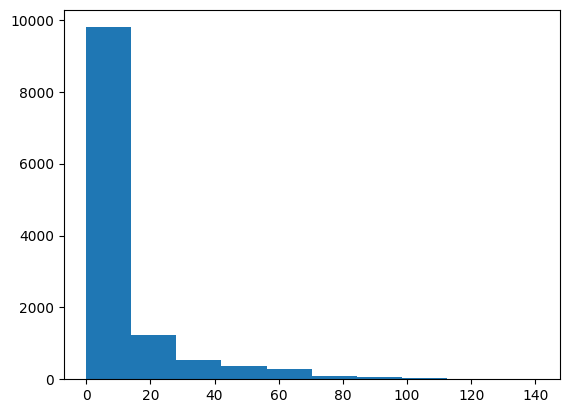

In [ ]:
#Check the distibution of score colum 
#Fans also tend to have extreme distribution based on loyalty within the app
import matplotlib.pyplot as plt

plt.hist(final_score.total)

In [ ]:
#Ranking of fans into three categories: steamed fans, prospective steamed fans, and sleeping fans
#Based on the total score, fans who exceed the average are classified as real fans, fans who are not active are classified as preliminary real fans, and fans who are not active at all are classified as sleeping fans

mean = final_score['total'].mean()

def allocate_groups(df):

    df_grouped = df.groupby(['chat_celeb_nickname', 'user_nickname']).sum().reset_index()
    
    df_grouped['allocation'] = df_grouped['total'].apply(lambda x: '찐팬' if x > mean else '예비찐팬') 

    return df_grouped

final_score = allocate_groups(final_score)

In [ ]:
final_score['allocation'].value_counts()

In [ ]:
final_score_ = final_score.copy()

final_score_ = final_score_.loc[:,['chat_celeb_nickname', 'user_nickname','made_message_length_x_scaled',
       'made_text_total_scaled', 'Liked_scaled', 'made_sticker_total_scaled',
       'made_sticker_freq_scaled', 'remain_test_scaled', 'total', 'allocation'] ]

In [ ]:
#quick check 

wi = final_score_[final_score_['chat_celeb_nickname'] =='위칭']
wi

In [ ]:
#quick check
wang = final_score_[final_score_['chat_celeb_nickname'] =='왕군']
wang 

In [ ]:
#churned users 
#Fans who were active 3 months ago and who are not active right now

%%bigquery inactive_fans --project add project name

SELECT 
  user_nickname, 
  chat_celeb_nickname,
  COUNT(DISTINCT IF(time BETWEEN '2022-12-01 00:00:00' AND '2023-03-31 23:59:59', chat_room_id, NULL)) AS active_rooms_last_3_months,
  COUNT(DISTINCT IF(time BETWEEN '2023-03-01 00:00:00' AND '2023-03-31 23:59:59', chat_room_id, NULL)) AS active_rooms_current_month
FROM 
  add project_name
WHERE 
  (chat_celeb_nickname!='') AND 
  (user_nickname != "") AND

  time BETWEEN '2022-12-01 00:00:00' AND '2023-03-31 23:59:59'
GROUP BY 
  user_nickname, 
  chat_celeb_nickname
HAVING 
  active_rooms_last_3_months > 0 AND 
  active_rooms_current_month = 0
ORDER BY 
  chat_celeb_nickname, 
  user_nickname


In [ ]:
final_score.head(1)

In [ ]:
inactive_fans['allocation'] = '잠든팬'
inactive_fans = inactive_fans.loc[:,['chat_celeb_nickname','user_nickname', 'allocation']]
inactive_fans.head(1)

In [ ]:
result = pd.concat([final_score, inactive_fans], axis=0) 

#quick check
result[result['chat_celeb_nickname'] =='왕군']

In [ ]:
result.to_csv('./Fancare_report_page3.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
